# Installing packages

In [1]:
!pip install pyarabic
!pip install pystemmer
!pip install optuna==2.3.0
!pip install transformers==4.2.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.0/303.0 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ | done
  Created wheel for pystemmer: filename=PyStemmer-2.2.0.1-cp310-cp310-linux_x86_64.whl size=225916 sha256=4a61c2aa7904169d6a638f918e34decd473be38ac89d4bb9981782306aa2f88f
  Stored in directory: /root/.cache/pip/wheels/45/7d/2c/a7ebb8319e01acc5306fa1f8558bf24063d6cec2c02de330c9
Successfully built pystemmer
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.6/258.6 kB 9.2 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / done
  Getting requirements to build wheel ... - \ done
  Preparing metadata (pyproject.toml) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.2/147.2 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━

#  Import packages

In [2]:
import numpy as np
import pandas as pd 
import os
import torch
import pyarabic.araby as ar
import re 
import Stemmer 
import functools
import operator
import string
import optuna 
import gc 
import random
import seaborn as sns
import matplotlib.pyplot as plt
import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_score , recall_score
from transformers import AutoTokenizer, AutoModel, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader,TensorDataset, RandomSampler, SequentialSampler
from torch.optim import Adam
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
from sklearn.utils import resample
import torch.nn as nn

import logging
logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger(__name__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [4]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/hespress/stories_faits-divers.csv
/kaggle/input/hespress/comments_marocains-du-monde.csv
/kaggle/input/hespress/stories_art-et-culture.csv
/kaggle/input/hespress/comments_regions.csv
/kaggle/input/hespress/comments_orbites.csv
/kaggle/input/hespress/stories_regions.csv
/kaggle/input/hespress/comments_art-et-culture.csv
/kaggle/input/hespress/stories_sport.csv
/kaggle/input/hespress/stories_medias.csv
/kaggle/input/hespress/comments_economie.csv
/kaggle/input/hespress/comments_medias.csv
/kaggle/input/hespress/stories_economie.csv
/kaggle/input/hespress/comments_sport.csv
/kaggle/input/hespress/comments_politique.csv
/kaggle/input/hespress/stories_tamazight.csv
/kaggle/input/hespress/stories_societe.csv
/kaggle/input/hespress/stories_orbites.csv
/kaggle/input/hespress/comments_societe.csv
/kaggle/input/hespress/stories_politique.csv
/kaggle/input/hespress/stories_marocains-du-monde.csv
/kaggle/input/hespress/comments_faits-divers.csv
/kaggle/input/hespress/comments_tamazig

In [5]:
csv_stories = [csv_file for csv_file in glob.glob('/kaggle/input/hespress/*.csv') if 'stories' in csv_file]
csv_comments = [csv_file for csv_file in glob.glob('/kaggle/input/hespress/*.csv') if 'comments' in csv_file]

# Create an empty DataFrame
stories_df = pd.DataFrame()
comments_df = pd.DataFrame()

# Iterate over the CSV files and add them to the DataFrame
for csv_file in csv_stories:
    df_temp = pd.read_csv(csv_file, index_col=0, encoding="utf-8")
    stories_df = pd.concat([stories_df, df_temp], ignore_index=True)
    
# Iterate over the CSV files and add them to the DataFrame
for csv_file in csv_comments:
    df_temp = pd.read_csv(csv_file, index_col=0, encoding="utf-8")
    comments_df = pd.concat([comments_df, df_temp], ignore_index=True)

In [6]:
stories_df.head()

,id,title,date,author,story,topic
0,9d9ebd0204f811eb92ec646e69d991ea,"شهادة طبيب جراح ""تورط"" قنصلا بتر أصبع مسنة",الجمعة 02 أكتوبر 2020 - 20:08,هسبريس من الدار البيضاء,قررت الغرفة الجنائية بمحكمة الاستئناف بمدينة ا...,faits-divers
1,9e96ecc604f811eb836a646e69d991ea,"إحباط تهريب أكثر من طن من ""الحشيش"" بأكادير",الجمعة 02 أكتوبر 2020 - 19:37,رشيد بيجيكن من أكادير,تمكنت المصلحة الولائية للشرطة القضائية بمدينة ...,faits-divers
2,9fc1ec4204f811eb8619646e69d991ea,كمين أمن الصويرة يسقط شبكة هجرة غير نظامية,الجمعة 02 أكتوبر 2020 - 18:35,ابراهيم مغراوي من مراكش,أوقفت عناصر فرقة الشرطة القضائية بالمنطقة الإق...,faits-divers
3,a0a2fa9c04f811eb8580646e69d991ea,"""تلميذة زاكورة"" تتهم زوج أختها باستغلالها جنسيا",الجمعة 02 أكتوبر 2020 - 14:20,هسبريس من زاكورة,كشف مصدر أمني مسؤول أن التلميذة المتحدرة من جم...,faits-divers
4,a2d0124a04f811eba88f646e69d991ea,"""أحجار كريمة مزيفة"" تورط أشخاصا بمدينة أكادير",الجمعة 02 أكتوبر 2020 - 10:05,رشيد بيجيكن من أكادير,تمكنت عناصر المصلحة الولائية للشرطة القضائية ب...,faits-divers


In [7]:
stories_df.head()

,id,title,date,author,story,topic
0,9d9ebd0204f811eb92ec646e69d991ea,"شهادة طبيب جراح ""تورط"" قنصلا بتر أصبع مسنة",الجمعة 02 أكتوبر 2020 - 20:08,هسبريس من الدار البيضاء,قررت الغرفة الجنائية بمحكمة الاستئناف بمدينة ا...,faits-divers
1,9e96ecc604f811eb836a646e69d991ea,"إحباط تهريب أكثر من طن من ""الحشيش"" بأكادير",الجمعة 02 أكتوبر 2020 - 19:37,رشيد بيجيكن من أكادير,تمكنت المصلحة الولائية للشرطة القضائية بمدينة ...,faits-divers
2,9fc1ec4204f811eb8619646e69d991ea,كمين أمن الصويرة يسقط شبكة هجرة غير نظامية,الجمعة 02 أكتوبر 2020 - 18:35,ابراهيم مغراوي من مراكش,أوقفت عناصر فرقة الشرطة القضائية بالمنطقة الإق...,faits-divers
3,a0a2fa9c04f811eb8580646e69d991ea,"""تلميذة زاكورة"" تتهم زوج أختها باستغلالها جنسيا",الجمعة 02 أكتوبر 2020 - 14:20,هسبريس من زاكورة,كشف مصدر أمني مسؤول أن التلميذة المتحدرة من جم...,faits-divers
4,a2d0124a04f811eba88f646e69d991ea,"""أحجار كريمة مزيفة"" تورط أشخاصا بمدينة أكادير",الجمعة 02 أكتوبر 2020 - 10:05,رشيد بيجيكن من أكادير,تمكنت عناصر المصلحة الولائية للشرطة القضائية ب...,faits-divers


# Preparing And Cleaning the data

In [8]:
comments_df.drop(columns=comments_df.columns[0:1], inplace=True)
stories_df.drop(columns=stories_df.columns[0:4], inplace=True)

topics = {"art-et-culture": "Art and Culture","economie": "Economy","faits-divers": "Miscellaneous","marocains-du-monde": "Moroccans of the world","medias": "Media","orbites": "Orbits","politique": "Politics","regions": "Religion","societe": "Society","sport": "Sport","tamazight": "Amazigh"}

comments_df['topic']  = comments_df['topic'].replace(topics)
stories_df['topic']  = stories_df['topic'].replace(topics)

In [9]:
comments_df.head()

,comment,score,topic
0,سيذكر التاريخ أن سياح أجانب دخلوا المغرب و موا...,428,Moroccans of the world
1,الحكومات لي كتحتارم شعوبها،رجعت مواطنين الحاصل...,303,Moroccans of the world
2,وايلي حتى فات الفوت عاد سولني كيف ابقيت ويلي و...,154,Moroccans of the world
3,الله اعلم لماذا كل هذا التأخر!!! شكرا على ستة ...,107,Moroccans of the world
4,لقد تأخرت السلطات المغربية كثيرا لإعادة هؤلاء ...,169,Moroccans of the world


In [10]:
stories_df.head()

,story,topic
0,قررت الغرفة الجنائية بمحكمة الاستئناف بمدينة ا...,Miscellaneous
1,تمكنت المصلحة الولائية للشرطة القضائية بمدينة ...,Miscellaneous
2,أوقفت عناصر فرقة الشرطة القضائية بالمنطقة الإق...,Miscellaneous
3,كشف مصدر أمني مسؤول أن التلميذة المتحدرة من جم...,Miscellaneous
4,تمكنت عناصر المصلحة الولائية للشرطة القضائية ب...,Miscellaneous


In [11]:
st =  Stemmer.Stemmer('arabic')

def clean (text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', str(text), flags=re.MULTILINE)
    text = re.sub(r'^http?:\/\/.*[\r\n]*', '', str(text), flags=re.MULTILINE)
    text = re.sub(r"http\S+", "", str(text))
    text = re.sub(r"https\S+", "", str(text))
    text = re.sub(r'\s+', ' ', str(text))
    text = re.sub("(\s\d+)","",str(text)) 
    text = re.sub(r"$\d+\W+|\b\d+\b|\W+\d+$", "", str(text))
    text = re.sub("\d+", " ", str(text))
    text = text.replace("#", " ");
    text = text.replace("@", " ");
    text = text.replace("_", " ");
    text = re.sub(r'(.)\1+', r'\1', text)
    text_stem = " ".join([st.stemWord(i) for i in text.split()])
    text = text +" "+ text_stem
    text = text.replace("آ", "ا")
    text = text.replace("إ", "ا")
    text = text.replace("أ", "ا")
    text = text.replace("ؤ", "و")
    text = text.replace("ئ", "ي")
    
    return text

In [12]:
stories_df['story'] = stories_df['story'].apply(lambda x: clean(x))
comments_df['comment'] = comments_df['comment'].apply(lambda x: clean(x))

In [13]:
stories_df['topic_id'] = stories_df['topic']
topic_ids = {"Art and Culture":0, "Economy" :1,"Miscellaneous":2,"Moroccans of the world":3,"Media":4, "Orbits":5, "Politics": 6,"Religion": 7, "Society":8, "Sport":9, "Amazigh": 10}
stories_df['topic_id']  = stories_df['topic_id'].replace(topic_ids)
stories_df

,story,topic,topic_id
0,قرت الغرفة الجنايية بمحكمة الاستيناف بمدينة ال...,Miscellaneous,2
1,تمكنت المصلحة الولايية لشرطة القضايية بمدينة ا...,Miscellaneous,2
2,اوقفت عناصر فرقة الشرطة القضايية بالمنطقة الاق...,Miscellaneous,2
3,كشف مصدر امني مسوول ان التلميذة المتحدرة من جم...,Miscellaneous,2
4,تمكنت عناصر المصلحة الولايية لشرطة القضايية بم...,Miscellaneous,2
...,...,...,...
10995,اعلنت وزارة التربية الوطنية والتكوين المهني وا...,Moroccans of the world,3
10996,لا يلفظ اسم العربي الحروشي في سلطنة عمان الا و...,Moroccans of the world,3
10997,طال المقام بالمغربية غزلان الصيابري في تجربة ا...,Moroccans of the world,3
10998,يعيش هشام تسمارت اواخر سنين العقد الثالث من حي...,Moroccans of the world,3


# EDA

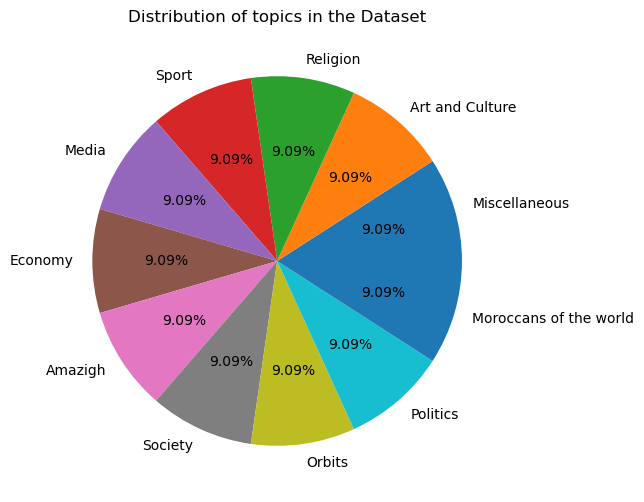

In [14]:
topics = stories_df.topic.value_counts()
plt.figure(figsize=(9,6))
plt.title("Distribution of topics in the Dataset")
plt.pie(topics, labels=topics.index, autopct='%.2f%%');

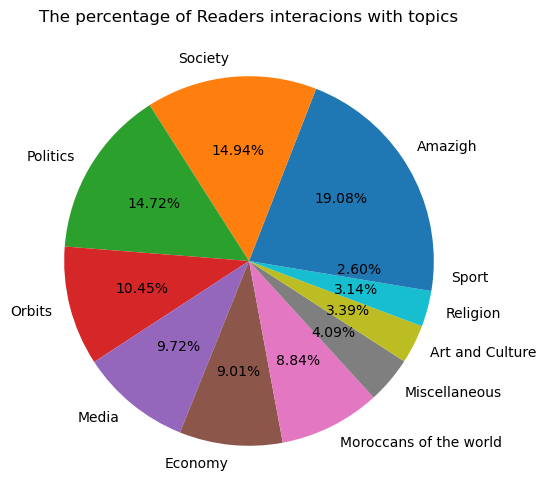

In [15]:
topics = comments_df.topic.value_counts()
plt.figure(figsize=(9,6))
plt.title("The percentage of Readers interacions with topics")
plt.pie(topics, labels=topics.index, autopct='%.2f%%');

In [16]:
comments_df.score.describe()

count    311515.000000
mean         18.131862
std          80.084768
min       -2199.000000
25%           0.000000
50%           6.000000
75%          21.000000
max        3824.000000
Name: score, dtype: float64

# Loading the Data

In [17]:
model_name = "asafaya/bert-base-arabic"
max_length = 128
batch_size = 32

In [18]:
stories_df.dropna()

stories_df = stories_df.sample(frac = 1)


In [19]:
stories_df.reset_index(drop=True, inplace=False)

,story,topic,topic_id
0,شد وزير الشوون الخارجية والتعاون الافريقي والم...,Politics,6
1,ندّدت النقابة الوطنية لتعليم العالي، التي تُمث...,Society,8
2,انطلق الموسم الدراسي-، صباح الاثنين، وسط اجواء...,Society,8
3,اكتشف تلاميذ موسّستَين تعليميتين من مدينة تمار...,Orbits,5
4,"اطلق مجموعة من الفنانين والاعلامين المغاربة ""ا...",Art and Culture,0
...,...,...,...
10995,لا تخفى التاثيرات الكبرى التي تخلّفها الازمات ...,Orbits,5
10996,"اعتبر محمد ضريف، رييس حزب ""الديمقراطيون الجد"" ...",Politics,6
10997,نبدا مطالعة انباء بعض الجرايد الورقية الخاصة ب...,Media,4
10998,في وقت تثير الايحة الوطنية لشباب والنساء جدلا ...,Politics,6


In [20]:
train_texts = stories_df.iloc[:7000]['story'].values
train_labels = stories_df.iloc[:7000]['topic_id'].values

valid_texts = stories_df.iloc[7000:9000]['story'].values
valid_labels = stories_df.iloc[7000:9000]['topic_id'].values

test_texts = stories_df.iloc[9000:]['story'].values
test_labels = stories_df.iloc[9000:]['topic_id'].values

In [21]:
tokenizer = AutoTokenizer.from_pretrained(model_name,model_max_length=128)

In [22]:
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
valid_encodings = tokenizer(list(valid_texts), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)

In [23]:
class HespressDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [24]:
train_dataset = HespressDataset(train_encodings, train_labels)
valid_dataset = HespressDataset(valid_encodings, valid_labels)
test_dataset = HespressDataset(test_encodings, test_labels)

In [25]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Building BERTModel for Topic Classification 

In [26]:
#set device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
model = BertForSequenceClassification.from_pretrained(model_name,num_labels=11,
                                                      output_attentions=False,output_hidden_states=False)
model.to(DEVICE)
model.train()
optim = torch.optim.Adam(model.parameters(), lr=5e-5)
NUM_EPOCHS = 3

Some weights of the model checkpoint at asafaya/bert-base-arabic were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at asafaya/bert-base-arabic and are newly initialized: ['classifier.weight', 'classifier.

In [28]:
def compute_accuracy(model, data_loader, device):
    with torch.no_grad():
        correct_pred, num_examples = 0, 0
        
        for batch_idx, batch in enumerate(data_loader):
        
        ### Prepare data
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs['logits']
            predicted_labels = torch.argmax(logits, 1)
            num_examples += labels.size(0)
            correct_pred += (predicted_labels == labels).sum()
        
        return correct_pred.float()/num_examples * 100

In [29]:
for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, batch in enumerate(train_loader):
        
        ### Prepare data
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        ### Forward
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs['loss'], outputs['logits']
        
        ### Backward
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        ### Logging
        if not batch_idx % 250:
            print (f'Epoch: {epoch+1:04d}/{NUM_EPOCHS:04d} | '
                   f'Batch {batch_idx:04d}/{len(train_loader):04d} | '
                   f'Loss: {loss:.4f}')
            
    model.eval()

    with torch.set_grad_enabled(False):
        print(f'Training accuracy: '
              f'{compute_accuracy(model, train_loader, DEVICE):.2f}%'
              f'\nValid accuracy: '
              f'{compute_accuracy(model, valid_loader, DEVICE):.2f}%')
        
    print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
    
print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')
print(f'Test accuracy: {compute_accuracy(model, test_loader, DEVICE):.2f}%')

Epoch: 0001/0003 | Batch 0000/0219 | Loss: 2.4800
Training accuracy: 89.93%
Valid accuracy: 84.70%


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:35                                                                                   │
│                                                                                                  │
│   32 │   │   │     f'\nValid accuracy: '                                                         │
│   33 │   │   │     f'{compute_accuracy(model, valid_loader, DEVICE):.2f}%')                      │
│   34 │                                                                                           │
│ ❱ 35 │   print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')                         │
│   36                                                                                             │
│   37 print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')                      │
│   38 print(f'Test accuracy: {compute_accuracy(model, test_loader, DEVICE):.2f}%')                │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'time' is not defined

# Testing The model

In [ ]:
model.eval()
model.to(DEVICE)
print(f'Test accuracy: {compute_accuracy(model, test_loader, DEVICE):.2f}%')